<a href="https://colab.research.google.com/github/bayuryunarko/ML-in-Financial-Analysis/blob/main/03MLFinancialAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Outliers

In [1]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 7.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=5a19819df4678bc028649b276bfea43b7593c39be0926d1390958efd90288289
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# import lib
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
# download data
df = yf.download('AAPL', 
                       start= '2000-01-01',
                       end = '2010-12-31',
                       progress= False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [4]:
# create simple returns
df['simple_rtn'] = df.adj_close.pct_change()

In [5]:
df.head()

,adj_close,simple_rtn
Date,,
2000-01-03,0.859423,NaN
2000-01-04,0.786965,-0.084310
2000-01-05,0.798481,0.014633
2000-01-06,0.729382,-0.086538
2000-01-07,0.763932,0.047369


In [6]:
# calculating the rolling mean and standard deviation
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling

simple_rtn          
                 mean       std
Date                           
2000-01-03        NaN       NaN
2000-01-04        NaN       NaN
2000-01-05        NaN       NaN
2000-01-06        NaN       NaN
2000-01-07        NaN       NaN
...               ...       ...
2010-12-23   0.002274  0.008078
2010-12-27   0.001496  0.007040
2010-12-28   0.001582  0.007040
2010-12-29   0.001273  0.006982
2010-12-30   0.001894  0.005625

[2766 rows x 2 columns]

In [7]:
df_rolling.columns = df_rolling.columns.droplevel()

In [8]:
df_rolling

,mean,std
Date,,
2000-01-03,NaN,NaN
2000-01-04,NaN,NaN
2000-01-05,NaN,NaN
2000-01-06,NaN,NaN
2000-01-07,NaN,NaN
...,...,...
2010-12-23,0.002274,0.008078
2010-12-27,0.001496,0.007040
2010-12-28,0.001582,0.007040


In [9]:
# joining the rolling metrics to the original data
df_outliers = df.join(df_rolling)
df_outliers

,adj_close,simple_rtn,mean,std
Date,,,,
2000-01-03,0.859423,NaN,NaN,NaN
2000-01-04,0.786965,-0.084310,NaN,NaN
2000-01-05,0.798481,0.014633,NaN,NaN
2000-01-06,0.729382,-0.086538,NaN,NaN
2000-01-07,0.763932,0.047369,NaN,NaN
...,...,...,...,...
2010-12-23,9.938018,-0.004798,0.002274,0.008078
2010-12-27,9.971185,0.003337,0.001496,0.007040
2010-12-28,9.995453,0.002434,0.001582,0.007040


In [10]:
# define a function for detecting outliers
def identify_outliers(row, n_sigma=3):
  '''
  Function for identifying the outliers using 3 sigma rules.
  The row must contain the following columns/indices: simple_rtn, mean, std.

  Parameters
  ----------
  row : pd.Series
  A row of pd.DataFrame, over which the function can be applied.
  n_sigma : int
  The number of standard deviation above/below the mean - used for detecting outliers

  Return
  ------
  0/1 : int
  An integer with 1 indicating an outlier and 0 otherwise.
  '''
  x = row['simple_rtn']
  mu = row['mean']
  sigma = row['std']

  if (x > mu + 3 * sigma) | (x < mu - 3 *sigma):
    return 1
  else:
    return 0

In [14]:
# identify the outliers and extract their values for later use
df_outliers['outlier'] = df_outliers.apply(identify_outliers, axis=1)

df_outliers.head()

,adj_close,simple_rtn,mean,std,outlier
Date,,,,,
2000-01-03,0.859423,NaN,NaN,NaN,0
2000-01-04,0.786965,-0.084310,NaN,NaN,0
2000-01-05,0.798481,0.014633,NaN,NaN,0
2000-01-06,0.729382,-0.086538,NaN,NaN,0
2000-01-07,0.763932,0.047369,NaN,NaN,0


In [16]:
outliers = df_outliers.loc[df_outliers['outlier'] ==1, ['simple_rtn']]
outliers

,simple_rtn
Date,
2000-09-29,-0.518692
2000-12-06,-0.158088
2001-07-18,-0.171713
2002-06-19,-0.150372
2003-04-11,-0.081420
2003-05-05,0.113491
2004-04-15,0.099850
2004-07-15,0.113253
2004-10-14,0.131573


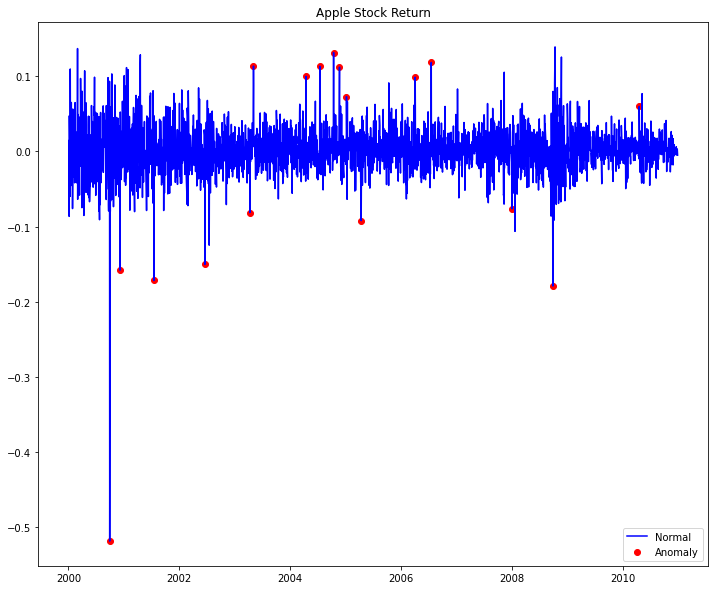

In [17]:
# plot the result
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(df_outliers.index, df_outliers.simple_rtn, color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title('Apple Stock Return')
ax.legend(loc='lower right')

plt.show()